<p align="center">
  <img src="docs/inference_sequence_diagram.png" alt="inferencing diagram" width="1200"/>
</p>

# TITLE & OVERVIEW

This notebook runs DEGIS image generation with two modes: Style (Base Ip-Adapter) and EMD-constrained (DEGIS Approach) color alignment.  
The notebook builds a hypothetical scenario where a car dealer, in interested in creating adsvertisements, that follows predefined colour and layout.
We evaluate three edge map and for each we use three color sources.  

Each evaluation section shows: the source color image, the chosen edge map, a style result, and an EMD-constrained result with metrics.

## ASSETS EXPECTED
- `embeddings`, `histograms`, `edge_maps`, and a trained `color_head`.  
- A ready `generator` pipeline.

## OUTPUTS OF INTEREST
- One visualization image per run.  
- Metrics: **EMD** (lower is better), **CLIP-text cosine** (higher is better), **attempts**, and **generation time**.


In [1]:
# =============================================================================
# ENVIRONMENT CHECK - Run this cell first!
# =============================================================================
# This cell verifies that the DEGIS environment is properly set up
# Make sure you've run ./setup_server_fixed.sh first!

import sys
import os

# Check if we're in the right environment
if 'degis-env' in sys.executable:
    print("DEGIS environment is active")
    print(f"Python: {sys.executable}")
else:
    print("Warning: DEGIS environment not detected")
    print("Please run: ./setup_server_fixed.sh")
    print("Then activate: source degis-env/bin/activate")

# Check if DEGIS package is available
try:
    import degis
    print("DEGIS package is available")
except ImportError:
    print("DEGIS package not found")
    print("Please run: ./setup_server_fixed.sh")

print("\nReady to start image generation!")

DEGIS environment is active
Python: /data/degis/degis-env/bin/python
DEGIS package is available

Ready to start image generation!


# IMPORTS — CONTEXT

Loads core libs (torch, numpy, PIL, matplotlib, torchvision), DEGIS dataset helpers, SDXL + ControlNet with DEGIS patches, and histogram utilities.  
Prints the active device (`cuda` or `cpu`). No parameters are changed here.

In [2]:
import geomloss
import numpy as np
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import DEGIS package components
from degis import IPAdapterXLGenerator, load_trained_color_head, get_color_embedding
from degis.shared.utils import plot_color_palette, display_images_grid, display_comparison_grid
from degis.shared.image_features.color_histograms import compute_color_histogram, compute_lab_histogram
from degis.shared.utils.image_utils import create_control_edge_pil
from degis.data.dataset import UnifiedImageDataset

# Import IP-Adapter XL with DEGIS patches
import ip_adapter_patch  # This applies the DEGIS patches
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

print("All imports successful!")
print("Ready for high-quality image generation with IP-Adapter XL!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

All imports successful!
Ready for high-quality image generation with IP-Adapter XL!
Using device: cuda


# PATHS & GLOBAL CONFIG

CSV manifest, embeddings `.npy`, histograms `.npy`, edge maps `.npy`, and the **color head checkpoint** paths.  
Define the **image encoder** and **ControlNet** identifiers.

In [3]:
csv_path = "/data/thesis/laion_5m_manifest.csv"
embeddings_path = "/data/thesis/models/hf_xl_laion_5m_embeddings.npy" # || YOUR_CUSTOM_PATH
colour_path = "/data/thesis/data/laion_5m_color_histograms_lab_514.npy" # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/evaluation_runs/laion_5m_xl_lab514_tk20_b4096/best_color_head_tmp.pth" # || YOUR_CUSTOM_PATH
precomputed_adimagenet_edge_maps_path = "/data/thesis/data/adimagenet_edge_maps.npy" # || YOUR_CUSTOM_PATH

image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"

# LOAD DATASETS & ARRAYS — EXPECTED SHAPES

Loads the thumbnail dataset (for selecting `colour_index`), memory-maps large arrays for **embeddings**, **histograms**, and **edge maps**, and loads the trained **color head**.  
Expect printed shapes for sanity checking.


In [4]:
from degis.inference import load_trained_color_head
# Load datasets
df = pd.read_csv(csv_path)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(precomputed_adimagenet_edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1280)
Loaded histograms: (3336240, 514)
Loaded edge maps: (2080, 50176)
✓ Color head loaded successfully


# HF CACHE SETUP & INITIALIZE PIPELINE

Sets local caches for Hugging Face components and initializes the IP-Adapter XL pipeline.  
First run may download weights; reruns use the cache.

In [5]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter XL generator
generator = IPAdapterXLGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet_id=controlnet_id,
    ip_ckpt=None,  # Update path as needed
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter XL pipeline setup complete")


Using cache directory: /data/hf-cache


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IP-Adapter sdxl checkpoint not found at h94/IP-Adapter
✓ Downloaded IP-Adapter sdxl checkpoint


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ IP-Adapter XL pipeline setup complete


# GENERATION FUNCTION — STYLE VS EMD

Reusable function to: clear VRAM, build control image, compute target histogram, run **Style** generation, run **EMD-constrained** generation, compute metrics, and render a composite visualization.


In [6]:
import torch, gc
from degis.inference import generate_by_style, generate_by_colour_emd_constrained
from degis.shared.utils.visualization import visualize_generation_comparison, create_generation_metrics
from degis.shared.utils.image_utils import create_control_edge_pil
from degis.inference.core_generation import get_color_embedding

def generate_comparison_snippet(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
    # EMD generation parameters
    target_emd_threshold: float = 0.1,
    max_attempts: int = 20,
    top_k: int = 20,
    color_space: str = None,
):
    """Simple snippet to generate both style and EMD images with visualization."""
    
    # Clear GPU memory
    gc.collect()
    torch.cuda.empty_cache()
    
    print(f"🎨 Generating comparison for colour_index={colour_index}, layout_index={layout_index}")
    print(f"📝 Prompt: '{prompt}'")
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = create_control_edge_pil(edge_maps[layout_index], size=512)
    
    # Compute color histogram for EMD constraint
    from degis.inference.generation_functions import compute_histogram_for_color_space, detect_color_space
    color_histogram = compute_histogram_for_color_space(pil_img, color_space or "lab", bins=8)
    if color_space is None:
        color_space = detect_color_space(color_histogram)
    
    print(f"📊 Color space: {color_space}, Histogram shape: {color_histogram.shape}")
    
    # 1. Style Generation (one-shot)
    print("\nRunning style generation...")
    import time
    start_time = time.time()
    
    style_images = generate_by_style(
        generator=generator,
        pil_image=pil_img,
        control_image=control_image,
        prompt=prompt,
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond
    )
    style_time = time.time() - start_time
    style_generated_image = style_images[0]
    
    # Calculate metrics for style generation
    from degis.inference.generation_functions import calculate_emd_distance_topk, calculate_cosine_similarity
    style_emd = calculate_emd_distance_topk(color_histogram, compute_histogram_for_color_space(style_generated_image, color_space, bins=8))
    style_cosine = calculate_cosine_similarity(prompt, style_generated_image)
    
    style_metrics = create_generation_metrics(
        generation_time=style_time,
        emd_score=style_emd,
        cosine_score=style_cosine
    )
    
    print(f"✅ Style generation: {style_time:.2f}s, EMD: {style_emd:.4f}, Cosine: {style_cosine:.4f}")
    
    # 2. EMD-Constrained Generation
    print("\nRunning EMD-constrained generation...")
    start_time = time.time()
    
    emd_images, emd_score, emd_cosine, attempts = generate_by_colour_emd_constrained(
        generator=generator,
        color_embedding=color_embedding,
        control_image=control_image,
        original_histogram=color_histogram,
        prompt=prompt,
        target_emd_threshold=target_emd_threshold,
        max_attempts=max_attempts,
        top_k=top_k,
        color_space=color_space,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
        verbose=True
    )
    emd_time = time.time() - start_time
    emd_generated_image = emd_images[0]
    
    emd_metrics = create_generation_metrics(
        generation_time=emd_time,
        emd_score=emd_score,
        cosine_score=emd_cosine,
        attempts=attempts
    )
    
    print(f"✅ EMD generation: {emd_time:.2f}s, EMD: {emd_score:.4f}, Cosine: {emd_cosine:.4f}, Attempts: {attempts}")
    
    # 3. Create comprehensive visualization
    print("\nCreating comprehensive visualization...")
    
    visualization = visualize_generation_comparison(
        color_source_image=pil_img,
        edge_map_image=control_image,
        style_generated_image=style_generated_image,
        emd_generated_image=emd_generated_image,
        color_histogram=color_histogram,
        color_space=color_space,
        style_metrics=style_metrics,
        emd_metrics=emd_metrics,
        grid_size=256,
        font_size=16
    )
    
    print(f"✅ Visualization created: {visualization.size}")
    print("Final comparison:")
    print(f"   Style: EMD={style_emd:.4f}, Cosine={style_cosine:.4f}")
    print(f"   EMD:   EMD={emd_score:.4f}, Cosine={emd_cosine:.4f}")
    
    from IPython.display import display
    display(visualization)
    
    return visualization, style_metrics, emd_metrics


# 1st Generation Scenario

We generate teh images using a fixed prompt and settings for comparability, same layout image, and three different versions of the advertisment with 3 different colour palettes


In [ ]:
visualization_30_1000, style_metrics_30_1000, emd_metrics_30_1000 = generate_comparison_snippet(
    colour_index=1000,
    layout_index=30,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)

In [ ]:
visualization_30_1001, style_metrics_30_1001, emd_metrics_30_1001 = generate_comparison_snippet(
    colour_index=1001,
    layout_index=30,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)

In [ ]:
visualization_30_1008, style_metrics_30_1008, emd_metrics_30_1008 = generate_comparison_snippet(
    colour_index=1008,
    layout_index=30,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)

# 2nd Generation Scenario

Similar to 2nd generation, but different layout image (footer banner)


In [ ]:
visualization_71_1000, style_metrics_71_1000, emd_metrics_71_1000 = generate_comparison_snippet(
    colour_index=1000,
    layout_index=71,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)

In [ ]:
visualization_71_1001, style_metrics_71_1001, emd_metrics_71_1001 = generate_comparison_snippet(
    colour_index=1001,
    layout_index=71,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)

In [ ]:
visualization_71_1008, style_metrics_71_1008, emd_metrics_71_1008 = generate_comparison_snippet(
    colour_index=1008,
    layout_index=71,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)


# 3rd Generations Scenario
Features 1 layout and 2 colour palettes, a prompt that doesn't describe the layout

In [ ]:
visualization_74_1000, style_metrics_74_1000, emd_metrics_74_1000 = generate_comparison_snippet(
    colour_index=1000,
    layout_index=400,
    prompt="a boat, advertisement style, professional photography",
    guidance_scale=7,
    steps=50,
    controlnet_conditioning_scale=0.4,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=2.5,
    ip_token_scale=0.7,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=1
)

In [ ]:
visualization_74_1000, style_metrics_74_1000, emd_metrics_74_1000 = generate_comparison_snippet(
    colour_index=1008,
    layout_index=507,
    prompt="a boat, advertisement style, professional photography",
    guidance_scale=7,
    steps=50,
    controlnet_conditioning_scale=0.4,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=3.5,
    ip_token_scale=0.9,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=5
)

In [ ]:
# --- helpers (edges, metrics) ---
import numpy as np, time, torch
from PIL import Image
try:
    from skimage.feature import canny as sk_canny
    from skimage.metrics import structural_similarity as ssim
    _HAS_SKIMAGE = True
except Exception:
    _HAS_SKIMAGE = False
from numpy.typing import ArrayLike

def _edge_from_pil(img: Image.Image, sigma: float = 1.0) -> np.ndarray:
    """0..1 float edge map from PIL image; uses skimage if available, else a simple Sobel fallback."""
    g = np.asarray(img.convert("L"), dtype=np.float32) / 255.0
    if _HAS_SKIMAGE:
        e = sk_canny(g, sigma=sigma).astype(np.float32)
    else:
        # Sobel fallback (no extra deps)
        gx = np.gradient(g, axis=1); gy = np.gradient(g, axis=0)
        mag = np.hypot(gx, gy)
        thr = np.quantile(mag, 0.90)
        e = (mag >= thr).astype(np.float32)
    return e

def _bin(x: ArrayLike, thr: float = 0.5) -> np.ndarray:
    return (np.asarray(x, dtype=np.float32) >= thr).astype(np.uint8)

def f1_iou(pred: ArrayLike, targ: ArrayLike, thr: float = 0.5):
    """F1 and IoU on binarised maps."""
    p = _bin(pred, thr); t = _bin(targ, thr)
    tp = np.sum((p == 1) & (t == 1))
    fp = np.sum((p == 1) & (t == 0))
    fn = np.sum((p == 0) & (t == 1))
    denom_f1 = (2*tp + fp + fn)
    f1 = (2*tp / denom_f1) if denom_f1 else 1.0
    denom_iou = (tp + fp + fn)
    iou = (tp / denom_iou) if denom_iou else 1.0
    return float(f1), float(iou)

# --- evaluation buffer ---
records = []  # each item is a dict (see below)

# --- one-shot case evaluator (returns a dict; does NOT mutate global state) ---
def evaluate_case(
    *,                                   # keyword-only for clarity
    colour_img: Image.Image,             # style reference image (PIL)
    control_edge_ref: Image.Image,       # reference edge map (PIL, 0..255)
    color_head,                          # trained colour head (nn.Module)
    generator,                           # IP-Adapter pipeline wrapper
    prompt: str,
    z_clip_row: np.ndarray,              # 1D numpy (D,)
    color_space: str = "lab",
    bins: int = 80,                      # for on-the-fly histogram + EMD
    # gauges
    attn_ip_scale: float = 0.7,
    text_token_scale: float = 1.2,
    ip_token_scale: float = 0.6,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
    # sampling
    guidance_scale: float = 8.0,
    steps: int = 60,
    controlnet_conditioning_scale: float = 0.7,
    # outer loop (only used in palette path helper if you set target)
    target_emd_threshold: float | None = None,
    max_attempts: int = 20,
    top_k: int = 20,
):
    """
    Runs (A) style baseline and (B) palette-tokens variant.
    Returns a single dict with EMD/CLIP/edge metrics & timings for both paths.
    """
    from degis.inference import generate_by_style, generate_by_colour_emd_constrained
    from degis.shared.utils.image_utils import create_control_edge_pil
    from degis.inference.generation_functions import (
        compute_histogram_for_color_space, calculate_emd_distance_topk, calculate_cosine_similarity,
        get_color_embedding
    )

    # prep common things
    t0 = time.time()
    z_clip = torch.tensor(z_clip_row, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu").unsqueeze(0)
    hist_color = compute_histogram_for_color_space(colour_img, color_space=color_space, bins=bins)
    # ref edges (0..1 float)
    edge_ref = np.asarray(control_edge_ref.convert("L"), dtype=np.float32) / 255.0

    # --- (A) style baseline ---
    tA = time.time()
    style_imgs = generate_by_style(
        generator=generator,
        pil_image=colour_img,
        control_image=control_edge_ref,
        prompt=prompt,
        num_samples=1,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=None,          # stock behaviour (style ref)
        ip_uncond_scale=None,
        zero_ip_in_uncond=False,
    )
    style_img = style_imgs[0]
    tA = time.time() - tA

    # metrics for style
    style_hist = compute_histogram_for_color_space(style_img, color_space=color_space, bins=bins)
    style_emd  = calculate_emd_distance_topk(hist_color, style_hist, top_k=top_k)
    style_cos  = calculate_cosine_similarity(prompt, style_img)
    style_edge = _edge_from_pil(style_img)
    style_f1, style_iou = f1_iou(style_edge, edge_ref, thr=0.5)
    style_ssim = float(ssim(edge_ref, style_edge)) if _HAS_SKIMAGE else np.nan

    # --- (B) palette-tokens path (with outer loop disabled by default) ---
    tB = time.time()
    color_emb = get_color_embedding(color_head, z_clip)  # [B, D]
    emd_imgs, emd_score, emd_cos, attempts = generate_by_colour_emd_constrained(
        generator=generator,
        color_embedding=color_emb,
        control_image=control_edge_ref,
        original_histogram=hist_color,
        prompt=prompt,
        target_emd_threshold=target_emd_threshold,
        max_attempts=max_attempts,
        top_k=top_k,
        color_space=color_space,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
        verbose=False
    )
    emd_img = emd_imgs[0]
    tB = time.time() - tB

    # metrics for palette path
    gen_hist  = compute_histogram_for_color_space(emd_img, color_space=color_space, bins=bins)
    gen_emd   = calculate_emd_distance_topk(hist_color, gen_hist, top_k=top_k)
    gen_cos   = calculate_cosine_similarity(prompt, emd_img)
    gen_edge  = _edge_from_pil(emd_img)
    gen_f1, gen_iou = f1_iou(gen_edge, edge_ref, thr=0.5)
    gen_ssim = float(ssim(edge_ref, gen_edge)) if _HAS_SKIMAGE else np.nan

    return {
        # reference
        "edge_ref": edge_ref,
        # style path
        "style_img": style_img, "style_time": tA, "emd_style": float(style_emd), "cos_style": float(style_cos),
        "edge_style": style_edge, "f1_style": style_f1, "iou_style": style_iou, "ssim_style": style_ssim,
        # palette path
        "emd_img": emd_img, "emd_time": tB, "emd_palette": float(gen_emd), "cos_palette": float(gen_cos),
        "edge_emd": gen_edge, "f1_emd": gen_f1, "iou_emd": gen_iou, "ssim_emd": gen_ssim,
        "attempts": int(attempts),
    }


In [ ]:
# thresholds to report
taus = [0.020, 0.025, 0.030]

emd_vals_palette = np.array([r["emd_palette"] for r in records], dtype=float)
emd_vals_style   = np.array([r["emd_style"]   for r in records], dtype=float)

def _pass_at_tau(arr, tau): return float(np.mean(arr <= tau))

print("Pass@τ (palette-tokens)  |  (style baseline)")
for t in taus:
    print(f"  τ={t:.3f}:  { _pass_at_tau(emd_vals_palette,t):.3f}   |   { _pass_at_tau(emd_vals_style,t):.3f}")


In [ ]:
delta = emd_vals_style - emd_vals_palette  # positive = our method improves
print(f"ΔEMD (style − palette): mean={delta.mean():.5f}, median={np.median(delta):.5f}")
# tiny text histogram (bins=7)
hist, edges = np.histogram(delta, bins=7)
print("hist ΔEMD:", hist.tolist())
print("bins:", [round(x,5) for x in edges.tolist()])


In [ ]:
f1_s = np.array([r["f1_style"] for r in records], dtype=float)
f1_p = np.array([r["f1_emd"]   for r in records], dtype=float)
iou_s = np.array([r["iou_style"] for r in records], dtype=float)
iou_p = np.array([r["iou_emd"]   for r in records], dtype=float)
ssim_s = np.array([r["ssim_style"] for r in records], dtype=float)
ssim_p = np.array([r["ssim_emd"]   for r in records], dtype=float)

def _m(m): return f"{np.nanmean(m):.3f}±{np.nanstd(m):.3f}"

print("Edge adherence  (mean±sd)")
print(f"  F1:   style={_m(f1_s)}   palette={_m(f1_p)}")
print(f"  IoU:  style={_m(iou_s)}  palette={_m(iou_p)}")
print(f"  SSIM: style={_m(ssim_s)} palette={_m(ssim_p)}  (nan if skimage not present)")


In [ ]:
cos_s = np.array([r["cos_style"] for r in records], dtype=float)
cos_p = np.array([r["cos_palette"] for r in records], dtype=float)
print(f"CLIP cosine — style:   mean={cos_s.mean():.4f}")
print(f"CLIP cosine — palette: mean={cos_p.mean():.4f}")
print(f"Δ (palette − style):   mean={(cos_p - cos_s).mean():.4f}")


In [ ]:
scales = [0.4, 0.7, 1.0]
subset_idx = list(range(min(20, len(records))))  # choose any subset of cases you've already staged
table = {s: [] for s in scales}

# We reuse the same inputs as the original record, but re-run only palette path:
for s in scales:
    vals = []
    for i in subset_idx:
        r = records[i]
        # rebuild a minimal call using the same scene inputs you used for r
        # tip: cache your raw inputs (colour_img, edge_ref PIL, z_clip row, prompt) alongside each record if you want this to be exact.
        # If you didn't cache them, just rerun your small data loader loop here to fetch them by index.
        # ---- example if you cached ----
        case = evaluate_case(
            colour_img=r["colour_img"],                 # <-- store these when creating records
            control_edge_ref=r["control_edge_ref"],
            color_head=color_head,
            generator=generator,
            prompt=r["prompt"],
            z_clip_row=r["z_clip_row"],
            ip_token_scale=s,
            text_token_scale=1.2,
            attn_ip_scale=0.7,
            zero_ip_in_uncond=True,
            ip_uncond_scale=0.0,
            guidance_scale=8.0, steps=60,
            controlnet_conditioning_scale=0.7,
        )
        vals.append(case["emd_palette"])
    table[s] = vals

print("EMD vs ip_token_scale (lower is better)")
for s in scales:
    arr = np.array(table[s], dtype=float)
    print(f"  {s:.1f}: mean={arr.mean():.4f}, median={np.median(arr):.4f}, n={len(arr)}")


In [ ]:
attempts = np.array([r["attempts"] for r in records], dtype=float)
emd_p     = np.array([r["emd_palette"] for r in records], dtype=float)

# success rates within a budget (e.g., 20 attempts) for thresholds:
taus = [0.020, 0.025, 0.030]
budget = 20
print(f"Attempts stats: mean={attempts.mean():.2f}, median={np.median(attempts):.1f}")
for t in taus:
    succ = (emd_p <= t) & (attempts <= budget)
    print(f"Success@{t:.3f} within {budget} attempts: {succ.mean():.3f}")


In [9]:
# # SNIPPET 0 — build a tidy evaluation DataFrame for N prompt/layout pairs (notebook-consistent)

import time, numpy as np, pandas as pd, torch, gc
from torchvision import transforms
from PIL import Image

from degis.inference import generate_by_style, generate_by_colour_emd_constrained
from degis.inference.core_generation import get_color_embedding
from degis.shared.utils.image_utils import create_control_edge_pil
from degis.inference.generation_functions import (
    compute_histogram_for_color_space,
    calculate_emd_distance_topk,
    calculate_cosine_similarity,
)

# ---- edge helpers (F1 / IoU / SSIM) ----
def _canny_bool(pil_img, sigma=1.0):
    import numpy as np
    try:
        from skimage.color import rgb2gray
        from skimage.feature import canny
        g = rgb2gray(np.asarray(pil_img).astype(np.float32) / 255.0)
        e = canny(g, sigma=sigma)
        return e.astype(np.uint8)
    except Exception:
        from PIL import ImageFilter
        e = pil_img.convert("L").filter(ImageFilter.FIND_EDGES)
        return (np.asarray(e) > 32).astype(np.uint8)

def _edge_scores(pred_bool, ref_bool):
    import numpy as np
    pred = pred_bool.astype(bool); ref = ref_bool.astype(bool)
    tp = np.logical_and(pred, ref).sum()
    fp = np.logical_and(pred, ~ref).sum()
    fn = np.logical_and(~pred, ref).sum()
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    iou  = tp / (tp + fp + fn + 1e-9)
    try:
        from skimage.metrics import structural_similarity as ssim
        ssimv = ssim(pred_bool.astype(np.float32), ref_bool.astype(np.float32))
    except Exception:
        ssimv = np.nan
    return f1, iou, ssimv

toPIL = transforms.ToPILImage()

@torch.no_grad()
def run_eval_pairs(
    pairs,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=7,
    steps=30,
    controlnet_conditioning_scale=0.5,
    attn_ip_scale=0.6,
    text_token_scale=1.5,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    # palette metrics
    colour_space="lab",
    bins=8,  # FIXED: Use same bins as generate_by_colour_emd_constrained default
    # EMD-constrained outer loop
    target_emd_threshold=0.02,
    max_attempts=20,
    top_k=20,
    verbose=False,
):
    rows = []
    dev = generator.device

    for colour_index, layout_index in pairs:
        gc.collect(); torch.cuda.empty_cache()

        # --- source PIL for style baseline + target histogram
        img_t, _ = colour_dataset[colour_index]         # uses your UnifiedImageDataset
        pil_img  = toPIL(img_t)

        target_hist = compute_histogram_for_color_space(pil_img, colour_space, bins=bins)

        # --- CLIP -> colour embedding from trained head
        z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=dev).unsqueeze(0)
        color_embedding = get_color_embedding(color_head, z_clip)  # notebook helper

        # --- control (edge) image + boolean mask for metrics
        control_img  = create_control_edge_pil(edge_maps[layout_index], size=512)
        control_bool = (np.asarray(control_img.convert("L")) > 0).astype(np.uint8)

        # ============ 1) STYLE baseline ============
        t0 = time.time()
        style_images = generate_by_style(
            generator=generator,
            pil_image=pil_img,                          # NOTE: pass PIL (not clip_image_embeds)
            control_image=control_img,
            prompt=prompt,
            num_samples=1,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            attn_ip_scale=attn_ip_scale,
            text_token_scale=text_token_scale,
            ip_token_scale=ip_token_scale,
            ip_uncond_scale=ip_uncond_scale,
            zero_ip_in_uncond=zero_ip_in_uncond,
        )
        style_time = time.time() - t0
        style_img  = style_images[0]

        style_hist = compute_histogram_for_color_space(style_img, colour_space, bins=bins)
        eval_top_k = min(top_k, len(target_hist)) if top_k is not None else len(target_hist)
        style_emd  = calculate_emd_distance_topk(target_hist, style_hist, top_k=eval_top_k, blur=0.01)

        style_cos  = calculate_cosine_similarity(prompt, style_img)
        f1_s, iou_s, ssim_s = _edge_scores(_canny_bool(style_img), control_bool)

        # ============ 2) EMD-constrained (palette tokens) ============
        t1 = time.time()
        emd_images, emd_score, emd_cos, attempts = generate_by_colour_emd_constrained(
            generator=generator,
            color_embedding=color_embedding,
            control_image=control_img,
            original_histogram=target_hist,
            prompt=prompt,
            target_emd_threshold=target_emd_threshold,
            max_attempts=max_attempts,
            top_k=top_k,
            color_space=colour_space,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            attn_ip_scale=attn_ip_scale,
            text_token_scale=text_token_scale,
            ip_token_scale=ip_token_scale,
            ip_uncond_scale=ip_uncond_scale,
            zero_ip_in_uncond=zero_ip_in_uncond,
            verbose=False,
        )
        emd_time = time.time() - t1
        emd_img  = emd_images[0]
        f1_e, iou_e, ssim_e = _edge_scores(_canny_bool(emd_img), control_bool)

        rows.append(dict(
            colour_index=int(colour_index),
            layout_index=int(layout_index),
            prompt=prompt,
            style_emd=float(style_emd), style_cos=float(style_cos),
            emd_emd=float(emd_score),   emd_cos=float(emd_cos),
            style_f1=float(f1_s), style_iou=float(iou_s), style_ssim=float(ssim_s),
            emd_f1=float(f1_e),   emd_iou=float(iou_e),   emd_ssim=float(ssim_e),
            attempts=int(attempts),
            style_time=float(style_time), emd_time=float(emd_time),
        ))
        if verbose:
            print(f"[{colour_index},{layout_index}] ΔEMD={style_emd-emd_score:+.5f} | attempts={attempts}")

    df = pd.DataFrame(rows)
    display(df.head())
    print(f"✓ Collected {len(df)} rows.")
    return df

# Example usage — use specific IDs for controlled evaluation
pairs = [(int(i), int(j)) for i in range(1000, 1020)  # colour_index: 1000-1019 (20 images)
         for j in [30, 71, 400, 507]]  # layout_index: 4 specific layouts

print("Testing these colour_index, layout_index pairs:")
for i, (c_idx, l_idx) in enumerate(pairs):
    print(f"  {i+1:2d}: colour_index={c_idx:7d}, layout_index={l_idx:4d}")
print(f"Total pairs: {len(pairs)}")  # Should be 20 * 4 = 80 pairs

df_eval = run_eval_pairs(pairs, target_emd_threshold=0.05, max_attempts=10, verbose=False)

Testing these colour_index, layout_index pairs:
   1: colour_index=   1000, layout_index=  30
   2: colour_index=   1000, layout_index=  71
   3: colour_index=   1000, layout_index= 400
   4: colour_index=   1000, layout_index= 507
   5: colour_index=   1001, layout_index=  30
   6: colour_index=   1001, layout_index=  71
   7: colour_index=   1001, layout_index= 400
   8: colour_index=   1001, layout_index= 507
   9: colour_index=   1002, layout_index=  30
  10: colour_index=   1002, layout_index=  71
  11: colour_index=   1002, layout_index= 400
  12: colour_index=   1002, layout_index= 507
  13: colour_index=   1003, layout_index=  30
  14: colour_index=   1003, layout_index=  71
  15: colour_index=   1003, layout_index= 400
  16: colour_index=   1003, layout_index= 507
  17: colour_index=   1004, layout_index=  30
  18: colour_index=   1004, layout_index=  71
  19: colour_index=   1004, layout_index= 400
  20: colour_index=   1004, layout_index= 507
  21: colour_index=   1005, layo

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time
0,1000,30,"a car, advertisement style, professional photo...",0.030160,0.293653,0.045867,0.249204,0.270998,0.156736,NaN,0.144221,0.077715,NaN,3,4.334205,12.917439
1,1000,71,"a car, advertisement style, professional photo...",0.027096,0.265515,0.047821,0.242300,0.216293,0.121261,NaN,0.263473,0.151724,NaN,3,4.285322,12.629453
2,1000,400,"a car, advertisement style, professional photo...",0.040245,0.213413,0.045376,0.226420,0.219109,0.123034,NaN,0.282617,0.164563,NaN,1,4.064584,4.200356
3,1000,507,"a car, advertisement style, professional photo...",0.052638,0.280722,0.039409,0.283436,0.266774,0.153917,NaN,0.286142,0.166958,NaN,1,4.218382,4.169845
4,1001,30,"a car, advertisement style, professional photo...",0.039230,0.284274,0.048048,0.290781,0.245168,0.139710,NaN,0.264076,0.152124,NaN,2,4.194600,8.451042


✓ Collected 80 rows.


In [10]:
# SNIPPET 1 — Pass@{0.020, 0.025, 0.030}

import numpy as np, pandas as pd

def pass_at_t(df, taus=(0.020, 0.025, 0.030), col="emd_emd"):
    out = []
    for t in taus:
        passed = (df[col].values <= t).mean()
        out.append({"tau": t, "pass_rate": float(passed)})
    res = pd.DataFrame(out)
    display(res)
    return res

print("Palette-token run (EMD-constrained):")
pass_at_t(df_eval, taus=(0.020, 0.025, 0.030), col="emd_emd")

print("\nSTYLE baseline (for context):")
pass_at_t(df_eval, taus=(0.020, 0.025, 0.030), col="style_emd")


Palette-token run (EMD-constrained):


,tau,pass_rate
0,0.020,0.0250
1,0.025,0.0875
2,0.030,0.1500



STYLE baseline (for context):


,tau,pass_rate
0,0.020,0.0625
1,0.025,0.0750
2,0.030,0.1250


,tau,pass_rate
0,0.020,0.0625
1,0.025,0.0750
2,0.030,0.1250


ΔEMD (style − palette): mean=0.00562, median=0.00271


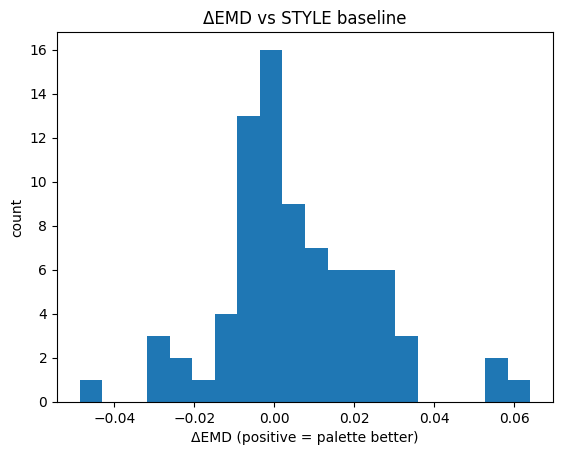

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time,delta_emd
19,1004,507,"a car, advertisement style, professional photo...",0.061121,0.307860,0.109771,0.284999,0.264081,0.152127,NaN,0.245235,0.139754,NaN,10,4.375974,42.441213,-0.048649
59,1014,507,"a car, advertisement style, professional photo...",0.014624,0.274361,0.043772,0.298230,0.236528,0.134127,NaN,0.230456,0.130235,NaN,1,4.138389,4.199854,-0.029149
47,1011,507,"a car, advertisement style, professional photo...",0.019944,0.355901,0.049030,0.295083,0.197328,0.109464,NaN,0.253174,0.144933,NaN,1,4.189779,4.389092,-0.029086
58,1014,400,"a car, advertisement style, professional photo...",0.011519,0.232765,0.039931,0.230706,0.240514,0.136695,NaN,0.218855,0.122873,NaN,1,4.131131,4.174191,-0.028412
11,1002,507,"a car, advertisement style, professional photo...",0.013551,0.256591,0.039114,0.257304,0.205056,0.114241,NaN,0.256906,0.147385,NaN,2,4.127692,8.652780,-0.025563


In [11]:
# SNIPPET 2 — paired improvement over STYLE baseline

import numpy as np, pandas as pd, matplotlib.pyplot as plt

df_delta = df_eval.assign(delta_emd = df_eval["style_emd"] - df_eval["emd_emd"])
print(f"ΔEMD (style − palette): mean={df_delta['delta_emd'].mean():.5f}, "
      f"median={df_delta['delta_emd'].median():.5f}")

# quick histogram
plt.figure()
plt.hist(df_delta["delta_emd"], bins=20)
plt.xlabel("ΔEMD (positive = palette better)"); plt.ylabel("count"); plt.title("ΔEMD vs STYLE baseline")
plt.show()

df_delta.sort_values("delta_emd", ascending=True).head(5)


ΔEMD (style − palette): mean=0.00562, median=0.00271


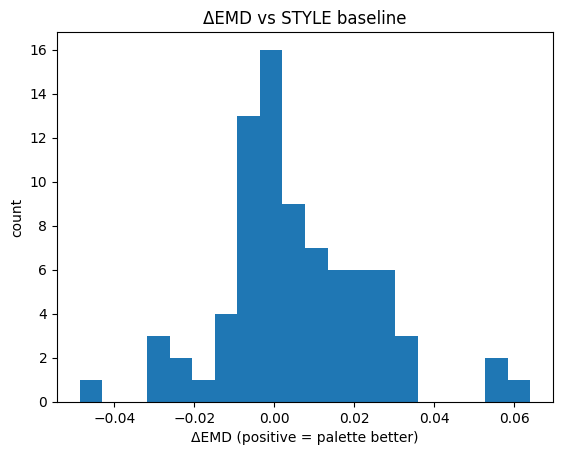

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time,delta_emd
19,1004,507,"a car, advertisement style, professional photo...",0.061121,0.307860,0.109771,0.284999,0.264081,0.152127,NaN,0.245235,0.139754,NaN,10,4.375974,42.441213,-0.048649
59,1014,507,"a car, advertisement style, professional photo...",0.014624,0.274361,0.043772,0.298230,0.236528,0.134127,NaN,0.230456,0.130235,NaN,1,4.138389,4.199854,-0.029149
47,1011,507,"a car, advertisement style, professional photo...",0.019944,0.355901,0.049030,0.295083,0.197328,0.109464,NaN,0.253174,0.144933,NaN,1,4.189779,4.389092,-0.029086
58,1014,400,"a car, advertisement style, professional photo...",0.011519,0.232765,0.039931,0.230706,0.240514,0.136695,NaN,0.218855,0.122873,NaN,1,4.131131,4.174191,-0.028412
11,1002,507,"a car, advertisement style, professional photo...",0.013551,0.256591,0.039114,0.257304,0.205056,0.114241,NaN,0.256906,0.147385,NaN,2,4.127692,8.652780,-0.025563


In [12]:
# SNIPPET 2 — paired improvement over STYLE baseline

import numpy as np, pandas as pd, matplotlib.pyplot as plt

df_delta = df_eval.assign(delta_emd = df_eval["style_emd"] - df_eval["emd_emd"])
print(f"ΔEMD (style − palette): mean={df_delta['delta_emd'].mean():.5f}, "
      f"median={df_delta['delta_emd'].median():.5f}")

# quick histogram
plt.figure()
plt.hist(df_delta["delta_emd"], bins=20)
plt.xlabel("ΔEMD (positive = palette better)"); plt.ylabel("count"); plt.title("ΔEMD vs STYLE baseline")
plt.show()

df_delta.sort_values("delta_emd", ascending=True).head(5)


In [13]:
# SNIPPET 3 — layout fidelity (edge F1 / IoU / SSIM)

def _brief_stats(x): 
    import numpy as np
    return f"mean={np.nanmean(x):.3f}  std={np.nanstd(x):.3f}"

print("STYLE   — F1:", _brief_stats(df_eval["style_f1"].values),
      "| IoU:", _brief_stats(df_eval["style_iou"].values),
      "| SSIM:", _brief_stats(df_eval["style_ssim"].values))

print("PALETTE — F1:", _brief_stats(df_eval["emd_f1"].values),
      "| IoU:", _brief_stats(df_eval["emd_iou"].values),
      "| SSIM:", _brief_stats(df_eval["emd_ssim"].values))


STYLE   — F1: mean=0.219  std=0.032 | IoU: mean=0.123  std=0.020 | SSIM: mean=nan  std=nan
PALETTE — F1: mean=0.245  std=0.040 | IoU: mean=0.140  std=0.026 | SSIM: mean=nan  std=nan


/tmp/ipykernel_2700804/3317066695.py:5: RuntimeWarning: Mean of empty slice
  return f"mean={np.nanmean(x):.3f}  std={np.nanstd(x):.3f}"
/data/degis/degis-env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [14]:
# SNIPPET 4 — text–image cosine (higher = better)

import numpy as np

m_style  = df_eval["style_cos"].mean()
m_emd    = df_eval["emd_cos"].mean()
delta    = (df_eval["emd_cos"] - df_eval["style_cos"]).mean()

print(f"CLIP cosine — STYLE mean={m_style:.4f} | PALETTE mean={m_emd:.4f} | Δ (palette−style)={delta:+.4f}")


CLIP cosine — STYLE mean=0.2624 | PALETTE mean=0.2543 | Δ (palette−style)=-0.0081


  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


/data/degis/degis/shared/clip_vit_h14.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time
0,1000,30,"a car, advertisement style, professional photo...",0.063960,0.269230,0.040400,0.239401,0.176403,0.096734,NaN,0.223803,0.126001,NaN,10,4.327113,41.428059
1,1000,71,"a car, advertisement style, professional photo...",0.033650,0.235521,0.043964,0.268805,0.227418,0.128297,NaN,0.293189,0.171776,NaN,10,4.297360,42.859748
2,1000,400,"a car, advertisement style, professional photo...",0.048929,0.179221,0.037587,0.200957,0.219589,0.123336,NaN,0.250887,0.143437,NaN,10,4.320712,42.673232
3,1000,507,"a car, advertisement style, professional photo...",0.049158,0.315065,0.036444,0.253695,0.187156,0.103239,NaN,0.246671,0.140687,NaN,10,4.104239,42.553766
4,1001,30,"a car, advertisement style, professional photo...",0.056118,0.211292,0.032475,0.219015,0.169956,0.092870,NaN,0.311107,0.184208,NaN,10,4.260360,41.258553


✓ Collected 10 rows.


  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


/data/degis/degis/shared/clip_vit_h14.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time
0,1000,30,"a car, advertisement style, professional photo...",0.048821,0.260543,0.042445,0.272395,0.224074,0.126173,NaN,0.254177,0.145592,NaN,10,4.142250,41.154607
1,1000,71,"a car, advertisement style, professional photo...",0.040154,0.293358,0.031020,0.258815,0.260585,0.149812,NaN,0.251765,0.144011,NaN,10,4.094496,41.293820
2,1000,400,"a car, advertisement style, professional photo...",0.029925,0.283008,0.039164,0.230251,0.204145,0.113676,NaN,0.275325,0.159639,NaN,10,4.214214,42.862659
3,1000,507,"a car, advertisement style, professional photo...",0.032445,0.254336,0.025551,0.275653,0.176309,0.096677,NaN,0.230548,0.130293,NaN,10,4.305960,43.032979
4,1001,30,"a car, advertisement style, professional photo...",0.041741,0.264586,0.029353,0.274731,0.222027,0.124876,NaN,0.202037,0.112370,NaN,10,4.398729,41.784308


✓ Collected 10 rows.


  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


/data/degis/degis/shared/clip_vit_h14.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

,colour_index,layout_index,prompt,style_emd,style_cos,emd_emd,emd_cos,style_f1,style_iou,style_ssim,emd_f1,emd_iou,emd_ssim,attempts,style_time,emd_time
0,1000,30,"a car, advertisement style, professional photo...",0.042688,0.309042,0.037372,0.284401,0.248014,0.141562,NaN,0.241621,0.137411,NaN,10,4.144516,42.795752
1,1000,71,"a car, advertisement style, professional photo...",0.033396,0.287776,0.032035,0.258652,0.251391,0.143766,NaN,0.295852,0.173607,NaN,10,4.134230,42.876081
2,1000,400,"a car, advertisement style, professional photo...",0.047510,0.227665,0.028950,0.223614,0.213835,0.119717,NaN,0.273851,0.158648,NaN,10,4.208970,41.990504
3,1000,507,"a car, advertisement style, professional photo...",0.029549,0.264470,0.032290,0.265528,0.187197,0.103264,NaN,0.226249,0.127554,NaN,10,4.333311,42.025208
4,1001,30,"a car, advertisement style, professional photo...",0.039701,0.251708,0.013397,0.286525,0.233320,0.132067,NaN,0.271955,0.157377,NaN,2,4.106067,8.412784


✓ Collected 10 rows.


,ip_token_scale,emd_mean,emd_median,pass@0.025
0,0.4,0.034035,0.036022,0.3
1,0.7,0.026845,0.029048,0.3
2,1.0,0.024410,0.025728,0.5


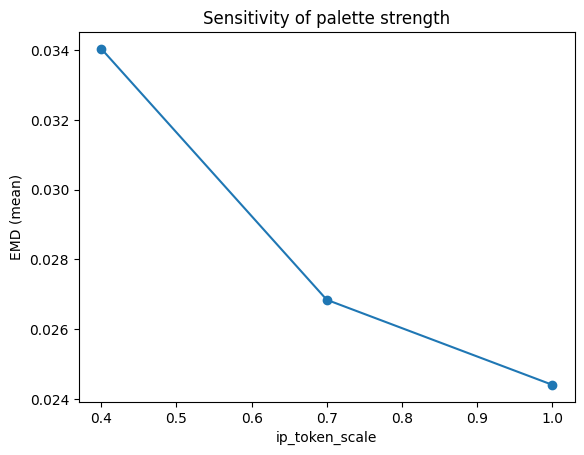

In [18]:
# SNIPPET 5 — sweep ip_token_scale ∈ {0.4, 0.7, 1.0} on a small subset

scales = [0.4, 0.7, 1.0]
subset_pairs = df_eval[["colour_index","layout_index"]].head(10).itertuples(index=False, name=None)

rows = []
for s in scales:
    df_s = run_eval_pairs(list(subset_pairs),
                          ip_token_scale=s,
                          target_emd_threshold=0.025,
                          max_attempts=10,
                          verbose=False)
    rows.append({"ip_token_scale": s,
                 "emd_mean": df_s["emd_emd"].mean(),
                 "emd_median": df_s["emd_emd"].median(),
                 "pass@0.025": (df_s["emd_emd"] <= 0.025).mean()})
    # reset iterator
    subset_pairs = df_eval[["colour_index","layout_index"]].head(10).itertuples(index=False, name=None)

df_sweep = pd.DataFrame(rows)
display(df_sweep)

# optional: tiny plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(df_sweep["ip_token_scale"], df_sweep["emd_mean"], marker="o")
plt.xlabel("ip_token_scale"); plt.ylabel("EMD (mean)"); plt.title("Sensitivity of palette strength")
plt.show()


Success@τ=0.025 within 20 attempts: 8.8%
Attempts for successful runs — mean=1.86, median=1.0, max=4


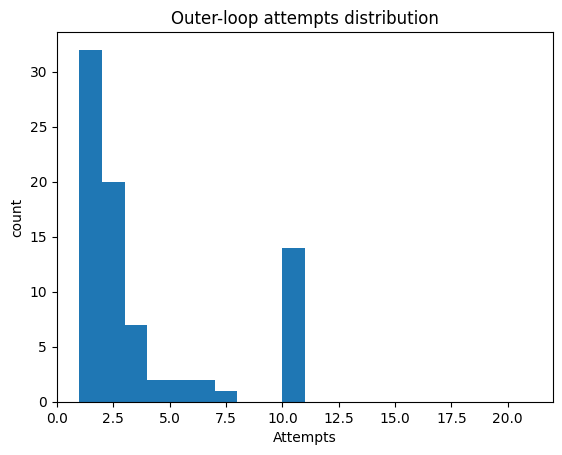

In [16]:
# SNIPPET 6 — attempts statistics and success rate within budget

tau = 0.025
budget = 20

succ = (df_eval["emd_emd"] <= tau).mean()
att_succ = df_eval.loc[df_eval["emd_emd"] <= tau, "attempts"]
print(f"Success@τ={tau:.3f} within {budget} attempts: {succ*100:.1f}%")
if len(att_succ):
    print(f"Attempts for successful runs — mean={att_succ.mean():.2f}, median={att_succ.median():.1f}, max={att_succ.max()}")

# quick histogram of attempts
import matplotlib.pyplot as plt
plt.figure()
plt.hist(df_eval["attempts"], bins=range(1, budget+2))
plt.xlabel("Attempts"); plt.ylabel("count"); plt.title("Outer-loop attempts distribution")
plt.show()


In [17]:
# SNIPPET 7 — trainable params added (lightweight claim)

import torch, json, glob, os

color_params = sum(p.numel() for p in color_head.parameters() if p.requires_grad)
rest_params  = None

# try to read rest from any best_summary.json (if present)
try:
    any_summary = sorted(glob.glob("evaluation_runs/**/best_summary.json", recursive=True))[0]
    with open(any_summary, "r") as f:
        js = json.load(f)
    rest_params = js.get("param_count_rest")
except Exception:
    pass

if rest_params is None:
    print(f"Trainable params — ColourHead: {color_params:,} (RestHead: n/a at inference)")
else:
    print(f"Trainable params — ColourHead: {color_params:,} | RestHead: {int(rest_params):,} | Total: {color_params+int(rest_params):,}")


Trainable params — ColourHead: 2,236,034 | RestHead: 1,968,896 | Total: 4,204,930


In [20]:
df_eval.to_csv("evaluation_runs/metrics.csv", index=False)